In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import random
from os import listdir
from PIL import Image
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

# Infrastructure code for dataset building  

In [2]:
class Subject:
    
    def __init__(self):
        self.label_image_dict= {}
    
    def add(self, image, label):
        self.label_image_dict[label] = image
    
    def get(self, label):
        return self.label_image_dict[label]

class Dataset:
    
    def __init__(self, data=[], labels=[]):
        self.data = []
        self.labels = []
    
    def to_numpy_array(self):
        self.data = np.array(self.data)
        self.labels = np.array(self.labels)
        
    def insert(self, datum, label):
        self.data.append(datum)
        self.labels.append(label)
    
    def extend(self, data, labels):
        self.data.extend(data)
        self.labels.extend(labels)
    
    def shuffle(self):
        idx = np.array(list(range(len(self.data))))
        np.random.shuffle(idx)
        self.data[:] = self.data[idx]
        self.labels[:] = self.labels[idx]
    
class DataBuilder:
    
    def __init__(self):
        self.subjects = defaultdict(Subject)
    
    def get_subject_ids(self):
        return list(self.subjects.keys())
    
    def load_data(self, data_dir="./CAFE/"):
        # Get the list of image file names
        all_files = listdir(data_dir)
        
        # Store the images and labels in self.subjects dictionary
        for file in all_files:
            # Load in the files as PIL images and convert to NumPy arrays
            subject, rest_string = file.split('_')
            label = rest_string.split('.')[0][:-1]
            
            # Exclude neutral and happy faces 
            if label != 'n' and label != 'h':
                img = Image.open(data_dir + file)
                self.subjects[subject].add(np.array(img, dtype=np.float64).reshape(-1, ), label) # Reshaped to a vector        
        
    def build_dataset(self, test_subject_id, labels):
        train, holdout, test, pca = Dataset(), Dataset(), Dataset(), []
        
        # Select data for train, holdout and test dataset
        subject_ids = self.get_subject_ids()
        test_subject = self.subjects[test_subject_id]
        subject_ids.remove(test_subject_id)
        
        holdout_subject_id = random.choice(subject_ids)
        holdout_subject = self.subjects[holdout_subject_id]
        subject_ids.remove(holdout_subject_id)
        
        for label in labels:
            test.insert(test_subject.get(label), label)
            holdout.insert(holdout_subject.get(label), label)
            train.extend([self.subjects[train_subject_id].get(label) for train_subject_id in subject_ids], [label] * len(subject_ids))
            
        # Select data for PCA
        for train_subject_id in subject_ids:
            pca.extend(list(self.subjects[train_subject_id].label_image_dict.values()))
        
        # To numpy array
        train.to_numpy_array()
        holdout.to_numpy_array()
        test.to_numpy_array()
        pca = np.array(pca)
        
        # Normalizatiton
        mean = np.mean(pca, axis=0)
        pca_normalized = (pca - mean)
        train.data = (train.data - mean) 
        holdout.data = (holdout.data - mean)
        test.data = (test.data - mean)
        
        return train, holdout, test, pca_normalized

# Utilities for image display

In [3]:
def display_face(img):
    """ Display the input image and optionally save as a PNG.
    Args:
        img: The NumPy array or image to display
    Returns: None
    """
    img = img.reshape(380, 240)
    # Convert img to PIL Image object (if it's an ndarray)
    if type(img) == np.ndarray:
        img = Image.fromarray(img)

    # Display the image
    plt.imshow(np.asarray(img), cmap='gray') # for jupyter notebook inline display
    plt.axis('off')
        
def display_faces(images, layout, labels):
    (n_row, n_col) = layout
    assert n_row*n_col == len(images) == len(labels)
    for i in range(len(images)):
        plt.subplot(n_row, n_col, i + 1)  # 1-6
        plt.title("{} face".format(labels[i]))
        display_face(images[i])

In [4]:
# class PCA:
    
#     def __init__(self, data):
#         """
#         data is stored row wise
#         """
#         self.data = data
#         self.eig_val, self.eig_vec = self.__pca__(data)
    
#     def __pca__(self, data):
#         """
#         returns: data transformed in 2 dims/columns + regenerated original data
#         pass in: data as 2D NumPy array
#         """ 
        
#         data -= data.mean(axis=0)

#         # Calculate covariance
#         cov = np.dot(data, data.T)

#         eig_vals, eig_vecs = np.linalg.eigh(cov)
        
#         # Map the eigenvectors to original ones
#         eig_vecs = np.dot(data.T, eig_vecs)
        
#         # Normalization
#         eig_vecs = eig_vecs / np.linalg.norm(eig_vecs, 2, axis=0)
# #         print(np.dot(data, eig_vecs[:,1:])/np.sqrt(eig_vals[1:]))
# #         print(np.var(np.dot(data, eig_vecs)))
# #         print(eig_vals)
#         return eig_vals[1:], eig_vecs[:, 1:]
    
#     def transform(self, data, n_components):
# #         selected_idx = self.sorted_idx[:n_components]
#         tran_data = np.dot(data, self.eig_vec[:, -n_components:])
# #         print("tran")
# #         print(tran_data / np.sqrt(self.eig_val[-n_components:]))
#         return tran_data / np.sqrt(self.eig_val[-n_components:])

In [5]:
x = np.array([[1,2,4,5],[2,3,6,7],[1,4,3,6]])
print(np.var(x, axis=0))
y = x-x.mean(axis=0)
z  = np.dot(y, y.T)
v, w = np.linalg.eigh(z)
print(v)
u = np.dot(y.T,y)
g,h =  np.linalg.eigh(u)
print(g)
# print(np.diag(u))
print(h)
r = np.dot(y.T, w)
r = r / np.linalg.norm(r, 2, axis=0)
r = r[:,1:]
print(r)
new_y = np.dot(y, r)
print(np.dot(new_y.T, new_y))
print(np.var(new_y, axis=0))

[0.22222222 0.66666667 1.55555556 0.66666667]
[1.45738792e-15 2.90283246e+00 6.43050087e+00]
[-1.28255434e-16  4.99486258e-16  2.90283246e+00  6.43050087e+00]
[[-0.84287326  0.42710867  0.07953533 -0.31751691]
 [-0.22198016 -0.52168322  0.8185381   0.09255701]
 [ 0.04423319 -0.49803958 -0.21043072 -0.84007078]
 [ 0.48819351  0.54532685  0.52857205 -0.42999686]]
[[ 0.07953533 -0.31751691]
 [ 0.8185381   0.09255701]
 [-0.21043072 -0.84007078]
 [ 0.52857205 -0.42999686]]
[[2.90283246e+00 2.57734637e-16]
 [2.57734637e-16 6.43050087e+00]]
[0.96761082 2.14350029]


In [6]:
class PCA:
    def __init__(self):
        None
        
    def learn(self, raw):
        # Subtract the mean
        self.mu = raw.mean(axis=0)
        raw -= self.mu

#         # Calculate covariance
        cov = np.dot(raw, raw.T)
        eig_vals, eig_vecs = np.linalg.eigh(cov)
        self.std = np.sqrt(eig_vals)[1:]

        # Map the eigenvectors to original ones
        eig_vecs = np.dot(raw.T, eig_vecs)[:, 1:]

        # Normalization
        self.transformer = eig_vecs / np.linalg.norm(eig_vecs, 2, axis=0)
        
    def run(self, data, n_components, normalize=True):
#         data = data - self.mu
        data = np.dot(data, self.transformer[:, -n_components:])
        if normalize:
            data = data / self.std[-n_components:]
        return data
    
    def plt_eig_faces(self, n_faces=6, layout=(2,3)):
        # display eigenfaces
        display_faces(self.transformer.T[0:n_faces], layout=layout, 
                      labels=["eigenface {}".format(i) for i in range(n_faces)])
        plt.savefig('Eigenfaces.png', bbox_inches='tight')

# Display 6 different emotional faces

# 1(c) Display eigen face

In [7]:
class Classifier:
    def __init__(self):
        self.train_set, self.holdout_set, self.test_set = None, None, None
        self.w = None
        
        self.test_accuracies = []
    
    def load_data(self, train, holdout, test):
        self.train_set, self.holdout_set, self.test_set = train, holdout, test
        
        label_set = list(set(self.train_set.labels))
        assert len(label_set) == 2
        
        self.encode = self.encoder(train.labels)
        
        for dataset in [self.train_set, self.holdout_set, self.test_set]:
            dataset.X = self.bias(dataset.data)
            dataset.y = self.encode(dataset.labels)
        
        self.test_set.y = np.array([True if (l - 1.0) < 1e-10 else False for l in self.test_set.y])
        
    def bias(self, data):
        return np.column_stack((np.ones(len(data)), data))

    def accuracy(self, test_set=None):
        if not test_set:
            test_set = self.test_set
#         y = np.argmax(y, axis=1)[:, np.newaxis]
        return np.sum(self.predict(test_set.X) == test_set.y) / len(test_set.y)
    
    def test(self):
        self.test_accuracies.append(self.accuracy())
        
    def train(self, T=10, lr=0.06, bs=None):
        
        # initialization
        train_X, train_y = self.train_set.X, self.train_set.y
        holdout_X, holdout_y = self.holdout_set.X, self.holdout_set.y
        self.train_losses, self.holdout_losses = [], []
        self.w = np.zeros((train_X.shape[1], train_y.shape[1]))
        self.W = []
#         self.W = np.array([])

        # gradient descent
        for t in range(T):
            # gradient descent on each batch
            if bs:
                # generate random permutation
                perm = np.random.permutation(len(train_X))
                for i in range(round(len(train_X)/bs)):
                    train_X_batch, train_y_batch = train_X[perm[i:i+bs]], train_y[perm[i:i+bs]]
                    self.w -= lr * self.gradient(train_X_batch, train_y_batch)
            else:
                self.w -= lr * self.gradient(train_X, train_y)
#                 print("temporary w: {}".format(self.w))
            self.W.append(self.w.tolist())
#             self.W = np.append(self.W, self.w)
#             print("temporary W: {}".format(self.W))
            
            # compute losses on train dataset and holdout dataset
            print("train losses")
            print(self.loss(train_X, train_y))
            self.train_losses.append(self.loss(train_X, train_y))
            self.holdout_losses.append(self.loss(holdout_X, holdout_y))
            
        # save the parameters with best performance
#         print("The W: {}".format(np.array(self.W)))
        self.w = np.array(min(self.W, key=lambda w: self.holdout_losses[self.W.index(w)]))
#         print(self.holdout_losses)
#         print(self.W)
#         print(np.array(self.W).shape)
#         print(self.w)

In [8]:
class LogisticClassifier(Classifier):
    
    def encoder(self, labels):
        label_set = list(set(labels))
        assert len(label_set) == 2
        binary_dict = {label_set[0]:0, label_set[1]:1}
        return lambda labels: np.array([binary_dict[label] for label in labels]).reshape(-1, 1)
    
    def logistic(self, s):
        return np.array(1 / (1 + np.exp(-s)))
    
    def predict(self, X):
        probs = self.logistic(np.dot(X, self.w))
        return np.array([1 for prob in probs if prob>0.5])

    def loss(self, X, y):
        y_hat = self.logistic(np.dot(X, self.w))
        print("logistic losses: {}".format(- np.dot(y.T, np.log(y_hat)) / len(y_hat)))
#         return - np.sum(y * np.log(y_hat)) / len(y_hat)
        return (- np.dot(y.T, np.log(y_hat)) / len(y_hat))[0][0]
    
    def gradient(self, X, y):
        y_hat = self.logistic(np.dot(X, self.w))
        return np.sum((y_hat - y) * X, axis=0).reshape(-1, 1) / len(X)

In [9]:
class SoftmaxClassifier(Classifier):
    
    def encoder(self, labels):
        label_set = list(set(labels))
        one_hot_dict = {label:one_hot for label, one_hot in zip(label_set, np.eye(len(label_set)))}
        return lambda labels: np.array([one_hot_dict[label] for label in labels])
    
    def softmax(self, s):
        return np.exp(s) / np.sum(np.exp(s), axis=1, keepdims=True)
    
    def predict(self, X):
        probs = self.softmax(np.dot(X, self.w))
        return np.argmax(probs, axis=1)[:, np.newaxis]

    def loss(self, X, y):
        y_hat = self.softmax(np.dot(X, self.w))
        print("softmax losses: {}".format(- np.sum(y * np.log(y_hat)) / len(y_hat)))
        return - np.sum(y * np.log(y_hat)) / len(y_hat)
    
    def gradient(self, X, y):
        y_hat = self.softmax(np.dot(X, self.w))
        return np.dot(X.T, (y_hat - y)) / len(X)

In [10]:
class Records:
    def __init__(self):
        
        self.train_losses = []
        self.holdout_losses = []
        self.test_accuracies = []
                
    def record(self, train_los, holdout_los, test_acc):
        self.train_losses.append(train_los)
        self.holdout_losses.append(holdout_los)
        self.test_accuracies.append(test_acc)
        
    def plt_losses(self, n_components, lr, n_epoches, train=True, holdout=True):
        assert len(self.train_losses) == len(self.holdout_losses)
        plt.figure()
        if train:
            plt.errorbar(range(n_epoches), np.mean(self.train_losses, axis=0), yerr=np.std(self.train_losses, axis=0))
        if holdout:
            plt.errorbar(range(n_epoches), np.mean(self.holdout_losses, axis=0), yerr=np.std(self.holdout_losses, axis=0))
        plt.title("n_components={}, learning_rates={}, n_epoches={}".format(n_components, lr, n_epoches))
        plt.show()
        
    def show_accuracies(self):
        print("The accuracy is {}".format(np.mean(self.test_accuracies)))

In [11]:
class Pipeline:
    
    def __init__(self, facial_expressions, dataset_dir='./CAFE/', classifier_type="logistic", pca=True):
        self.facial_expressions = facial_expressions
        
        self.data_builder = DataBuilder()
        self.data_builder.load_data(dataset_dir)
        
        if classifier_type=="logistic":
            self.classifier = LogisticClassifier()
        elif classifier_type=="softmax":
            self.classifier = SoftmaxClassifier()
            
        if pca:
            self.PCA = PCA()
            
        self.records = Records()
        
    def build(self, n_components, learning_rate, n_epoches, batch_size=None, n_repeats=10):
        self.n_components = n_components
        self.learning_rate = learning_rate
        self.n_epoches = n_epoches
        self.batch_size = batch_size
        self.n_repeats = n_repeats
    
    def run(self):
        
        subjects = self.data_builder.get_subject_ids()
        print("subject: {}".format(subjects))
        for repeat in range(self.n_repeats):
            for test_subject in subjects:
                # Dataset building
                train, holdout, test, pca_data = self.data_builder.build_dataset(test_subject, self.facial_expressions)
                self.PCA.learn(pca_data)
                
                train.data = self.PCA.run(train.data, self.n_components)
                holdout.data = self.PCA.run(holdout.data, self.n_components)
                test.data = self.PCA.run(test.data, self.n_components)

                # Run classification algorithm
                self.classifier.load_data(train, holdout, test)
                self.classifier.train(lr=self.learning_rate, T=self.n_epoches, bs=self.batch_size)
                self.classifier.test()
                self.records.record(self.classifier.train_losses, self.classifier.holdout_losses, self.classifier.test_accuracies)
    

# 2.(b)

subject: ['043', '044', '036', '018', '041', '048ng', '037', '049', '027', '050']
train losses
logistic losses: [[0.2732588]]
0.27325879607062525
logistic losses: [[0.2732588]]
logistic losses: [[0.37695793]]
train losses
logistic losses: [[0.21614792]]
0.21614792355311768
logistic losses: [[0.21614792]]
logistic losses: [[0.39510337]]
train losses
logistic losses: [[0.18410493]]
0.1841049282145388
logistic losses: [[0.18410493]]
logistic losses: [[0.42566045]]
train losses
logistic losses: [[0.14883961]]
0.14883961255996636
logistic losses: [[0.14883961]]
logistic losses: [[0.42891822]]
train losses
logistic losses: [[0.13619309]]
0.1361930912490127
logistic losses: [[0.13619309]]
logistic losses: [[0.46460987]]
train losses
logistic losses: [[0.11162216]]
0.11162215584296163
logistic losses: [[0.11162216]]
logistic losses: [[0.45690132]]
train losses
logistic losses: [[0.10551238]]
0.10551237620386257
logistic losses: [[0.10551238]]
logistic losses: [[0.49073598]]
train losses
logist

train losses
logistic losses: [[0.27254622]]
0.2725462192790694
logistic losses: [[0.27254622]]
logistic losses: [[0.3087149]]
train losses
logistic losses: [[0.21610481]]
0.21610481186815467
logistic losses: [[0.21610481]]
logistic losses: [[0.27357772]]
train losses
logistic losses: [[0.18302681]]
0.1830268078438081
logistic losses: [[0.18302681]]
logistic losses: [[0.25402765]]
train losses
logistic losses: [[0.14912787]]
0.14912787453413084
logistic losses: [[0.14912787]]
logistic losses: [[0.22579182]]
train losses
logistic losses: [[0.13501607]]
0.1350160694486887
logistic losses: [[0.13501607]]
logistic losses: [[0.21825581]]
train losses
logistic losses: [[0.11197511]]
0.11197511305166852
logistic losses: [[0.11197511]]
logistic losses: [[0.19426647]]
train losses
logistic losses: [[0.10466715]]
0.10466715419815764
logistic losses: [[0.10466715]]
logistic losses: [[0.19079453]]
train losses
logistic losses: [[0.09015299]]
0.09015298859100918
logistic losses: [[0.09015299]]
logi

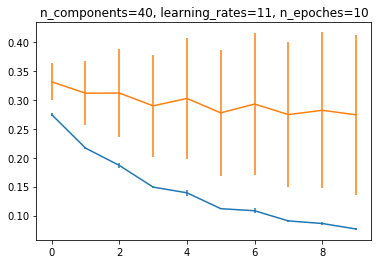

The accuracy is 0.9


In [25]:
# n_components = [20, 30, 40]
# learning_rates = [0.01, 0.02, 0.03, 0.04, 0.05] # 10] # 0.01 - 1

n_components = [40]
learning_rates = [11]
n_epoches = 10
for n_comp in n_components:
    for lr in learning_rates:
        
#         pipeline = Pipeline(facial_expressions=['ht','m'], classifier_type="softmax")
        pipeline = Pipeline(facial_expressions=['ht','m'], classifier_type="logistic")
        pipeline.build(n_components=n_comp, learning_rate=lr, n_epoches=n_epoches, batch_size=None, n_repeats=1)
        pipeline.run()
        
        # plot errors
        pipeline.records.plt_losses(n_components=n_comp, lr=lr, n_epoches=n_epoches)
        pipeline.records.show_accuracies()


# 2.(c)

# 3.(a)

# 3.(b)